In [1]:
from google.colab import files
uploaded = files.upload()

import os
print("Files now in working dir:", os.listdir())


Saving xy_data.csv to xy_data.csv
Files now in working dir: ['.config', 'xy_data.csv', 'sample_data']


In [2]:
import pandas as pd
fn = "xy_data.csv"
df = pd.read_csv(fn)
print("Columns:", df.columns.tolist())
print("Number of rows:", len(df))
df.head(8)


Columns: ['x', 'y']
Number of rows: 1500


,x,y
0,88.364456,57.784378
1,74.283936,54.406780
2,60.256474,46.311462
3,82.134370,57.717567
4,101.036390,67.849340
5,69.284134,48.406086
6,77.810130,57.588833
7,91.296880,63.031350


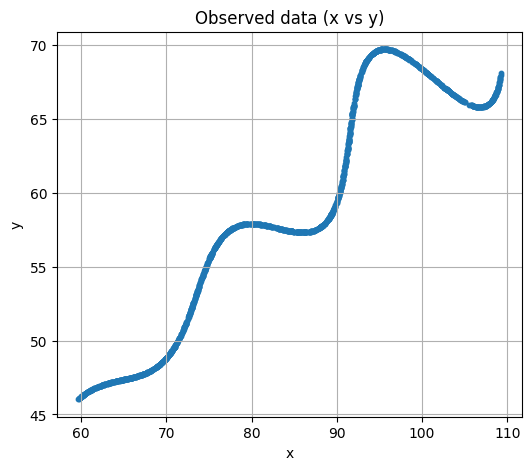

In [3]:
import numpy as np
import matplotlib.pyplot as plt

if list(df.columns)[:2] != ['x','y']:
    df = df.iloc[:, :2]
    df.columns = ['x','y']

n = len(df)
t = np.linspace(6.0, 60.0, n)
x_obs = df['x'].values
y_obs = df['y'].values

plt.figure(figsize=(6,5))
plt.scatter(x_obs, y_obs, s=10)
plt.title("Observed data (x vs y)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [4]:
import math

def model(params, tarr):
    theta, M, X = params
    x = tarr * np.cos(theta) - np.exp(M * np.abs(tarr)) * np.sin(0.3 * tarr) * np.sin(theta) + X
    y = 42 + tarr * np.sin(theta) + np.exp(M * np.abs(tarr)) * np.sin(0.3 * tarr) * np.cos(theta)
    return x, y

def l1_obj(params):
    xp, yp = model(params, t)
    return np.sum(np.abs(xp - x_obs) + np.abs(yp - y_obs))

def l2_obj(params):
    xp, yp = model(params, t)
    return np.sum((xp - x_obs)**2 + (yp - y_obs)**2)

bounds = [(0.0, 50*math.pi/180), (-0.05, 0.05), (0.0, 100.0)]


In [5]:
from scipy.optimize import minimize

starts = [
    [0.5, 0.0, 10.0],
    [0.4, 0.01, 50.0],
    [0.3, -0.01, 30.0],
    [0.8, 0.02, 60.0],
]

best_l2 = None
best_l2_params = None
for s in starts:
    r = minimize(l2_obj, x0=s, bounds=bounds, method="L-BFGS-B")
    if best_l2 is None or r.fun < best_l2:
        best_l2 = r.fun
        best_l2_params = r.x

print("Best warm-start (L2) params:", best_l2_params, "cost:", best_l2)

import numpy.random as npr
candidates = [best_l2_params]
rng = npr.default_rng(123)
for _ in range(6):
    cand = [rng.uniform(0.01, 50*math.pi/180), rng.uniform(-0.04, 0.04), rng.uniform(0.0, 100.0)]
    candidates.append(cand)

best_l1 = None
best_params = None
for c in candidates:
    r = minimize(l1_obj, x0=c, bounds=bounds, method="L-BFGS-B", options={"maxiter":200000})
    if best_l1 is None or r.fun < best_l1:
        best_l1 = r.fun
        best_params = r.x

theta_opt, M_opt, X_opt = best_params
theta_deg = theta_opt * 180.0 / math.pi

print("\nFinal optimized parameters:")
print("theta (radians):", theta_opt)
print("theta (degrees):", theta_deg)
print("M:", M_opt)
print("X:", X_opt)
print("Total L1:", best_l1)
print("Mean L1 per sample:", best_l1 / n)


Best warm-start (L2) params: [ 5.16317547e-01 -5.00000000e-02  5.50136091e+01] cost: 771686.8923633036

Final optimized parameters:
theta (radians): 0.4907592312245263
theta (degrees): 28.118432706250243
M: 0.021388895209001085
X: 54.89817581412459
Total L1: 37865.093853853534
Mean L1 per sample: 25.243395902569024


In [6]:
x_pred, y_pred = model(best_params, t)

out_df = pd.DataFrame({
    "t": t,
    "x_obs": x_obs,
    "y_obs": y_obs,
    "x_pred": x_pred,
    "y_pred": y_pred
})
out_df.to_csv("xy_predictions.csv", index=False)
print("Saved xy_predictions.csv")

out_df.head(8)


Saved xy_predictions.csv


,t,x_obs,y_obs,x_pred,y_pred
0,6.000000,88.364456,57.784378,59.668210,45.804296
1,6.036024,74.283936,54.406780,59.700927,45.819505
2,6.072048,60.256474,46.311462,59.733707,45.834598
3,6.108072,82.134370,57.717567,59.766549,45.849573
4,6.144096,101.036390,67.849340,59.799454,45.864431
5,6.180120,69.284134,48.406086,59.832422,45.879172
6,6.216144,77.810130,57.588833,59.865452,45.893796
7,6.252168,91.296880,63.031350,59.898545,45.908303


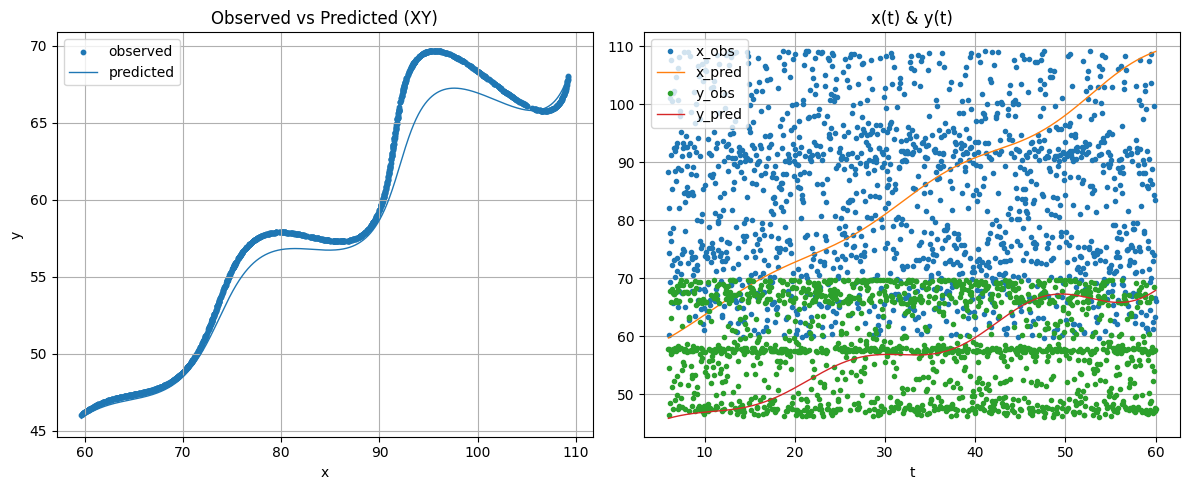

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(x_obs, y_obs, s=10, label="observed")
plt.plot(x_pred, y_pred, '-', linewidth=1, label="predicted")
plt.legend(); plt.title("Observed vs Predicted (XY)"); plt.xlabel("x"); plt.ylabel("y"); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(t, x_obs, 'o', markersize=3, label="x_obs")
plt.plot(t, x_pred, '-', linewidth=1, label="x_pred")
plt.plot(t, y_obs, 'o', markersize=3, label="y_obs")
plt.plot(t, y_pred, '-', linewidth=1, label="y_pred")
plt.legend(); plt.title("x(t) & y(t)"); plt.xlabel("t"); plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
equation = (
    f"(t*\\cos({theta_deg:.6f}\\deg) - e^{{{M_opt:.6f}|t|}}\\cdot\\sin(0.3t)\\sin({theta_deg:.6f}\\deg) + {X_opt:.6f}, "
    f"42 + t*\\sin({theta_deg:.6f}\\deg) + e^{{{M_opt:.6f}|t|}}\\cdot\\sin(0.3t)\\cos({theta_deg:.6f}\\deg))"
)
print("Final fitted equation (LaTeX-style):\n", equation)
print("\nSuggested README excerpt:\n")
print(f"""Final fitted parameters:
- theta = {theta_deg:.6f} degrees
- M     = {M_opt:.6f}
- X     = {X_opt:.6f}

Total L1 = {best_l1:.6f}
Mean L1 per sample = {best_l1 / n:.6f}

Equation:
(t*cos({theta_deg:.6f}°) - exp({M_opt:.6f}|t|)*sin(0.3t)*sin({theta_deg:.6f}°) + {X_opt:.6f},
 42 + t*sin({theta_deg:.6f}°) + exp({M_opt:.6f}|t|)*sin(0.3t)*cos({theta_deg:.6f}°))
""")


Final fitted equation (LaTeX-style):
 (t*\cos(28.118433\deg) - e^{0.021389|t|}\cdot\sin(0.3t)\sin(28.118433\deg) + 54.898176, 42 + t*\sin(28.118433\deg) + e^{0.021389|t|}\cdot\sin(0.3t)\cos(28.118433\deg))

Suggested README excerpt:

Final fitted parameters:
- theta = 28.118433 degrees
- M     = 0.021389
- X     = 54.898176

Total L1 = 37865.093854
Mean L1 per sample = 25.243396

Equation:
(t*cos(28.118433°) - exp(0.021389|t|)*sin(0.3t)*sin(28.118433°) + 54.898176,
 42 + t*sin(28.118433°) + exp(0.021389|t|)*sin(0.3t)*cos(28.118433°))



In [9]:
plt.figure(figsize=(8,5))
plt.scatter(x_obs, y_obs, s=8, label='observed')
plt.plot(x_pred, y_pred, '-', label='predicted')
plt.legend()
plt.title('XY observed vs predicted')
plt.savefig("xy_fit_scatter.png", dpi=200)
plt.close()
print("Saved xy_fit_scatter.png and xy_predictions.csv.")

from google.colab import files
files.download("xy_predictions.csv")
files.download("xy_fit_scatter.png")


Saved xy_fit_scatter.png and xy_predictions.csv.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>